In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("StudentPerformanceFactors.csv")
df.columns


Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

In [3]:
#data cleaning
normalization_dict = {
    'Low': 0.33,
    'Medium': 0.66,
    'High': 0.99,
    'No': 0,
    'Yes': 1,
    'Public': 1,
    'Private': 0,
    'Positive': 1,
    'Neutral': 0.5,
    'Negative': 0,
    'High School': 0.33,
    'College': 0.66,
    'Postgraduate': 0.99,
    'Near': 0,
    'Moderate': 0.5,
    'Far': 1,
    'Male': 1,
    'Female':0,

}

# Use the mapping for regularization
df_normalized = df.copy()

for column in df_normalized.columns:
    if df_normalized[column].dtype == 'object': 
        df_normalized[column] = df_normalized[column].map(normalization_dict)


#check missing
null_values = df_normalized.isna().sum()
print(null_values)



Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


##### Teacher_Quality,Parental_Education_Level,Distance_from_Home have some missing value, but not too much ,del it

In [4]:
df_normalized.dropna(inplace=True)

In [5]:
np.any(df_normalized.duplicated())#check duplicate

False

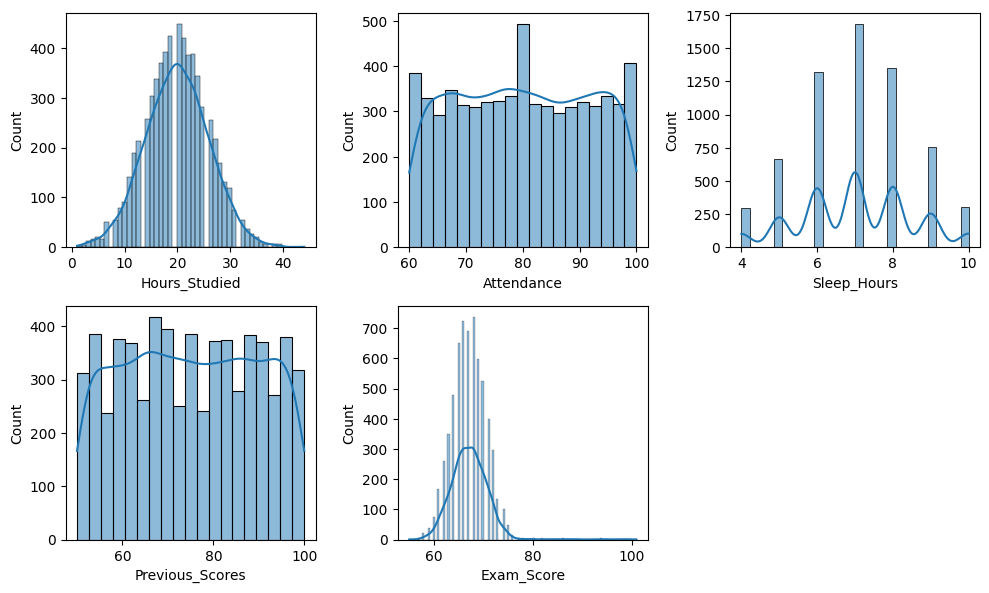

In [6]:
features = [
    'Hours_Studied',
    'Attendance',
    'Sleep_Hours',
    'Previous_Scores',
    'Exam_Score',
]

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

axes = axes.flatten()

for i, feature_x in enumerate(features):
    sns.histplot(df_normalized[feature_x], kde = True,ax=axes[i])

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

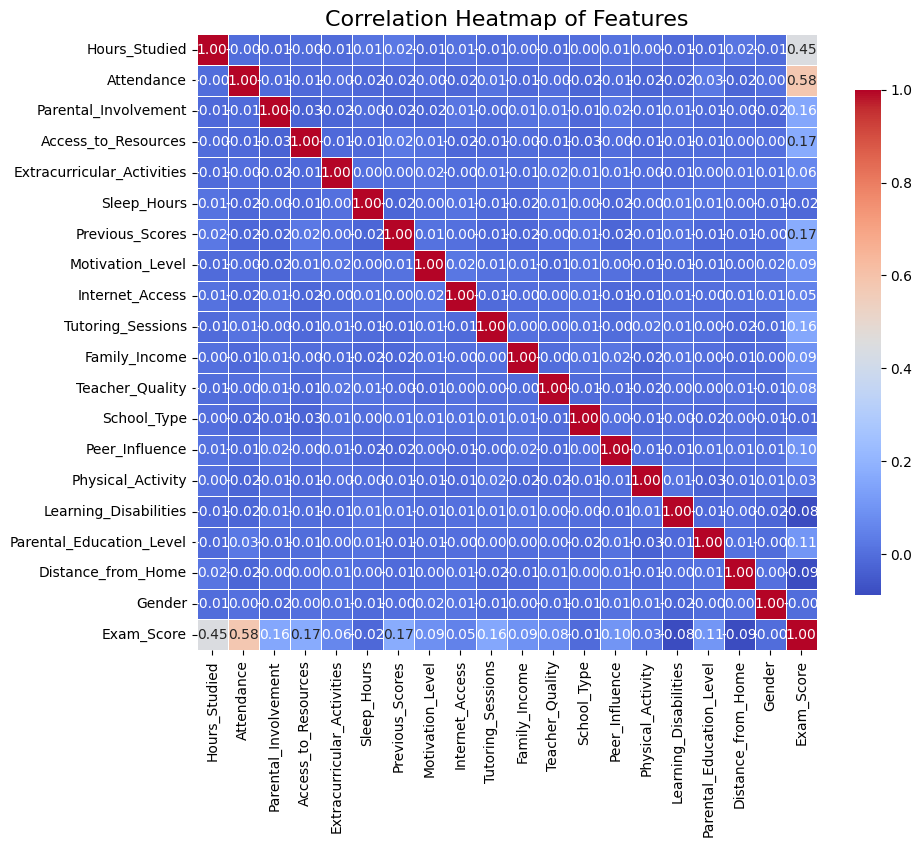

In [25]:
#Pearson correlation coefficient
df_corr = df_normalized.corr(method="pearson")
df_corr
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .82})

plt.title("Correlation Heatmap of Features", fontsize=16)

plt.show()


### It seems that some feature have a slight positive correlation.
#### Exam_score <-> Hours_Studied (0.45)
#### Exam_score <-> Attendance (0.58)
#### Previous_Scores <-> Exam_Score (0.17)

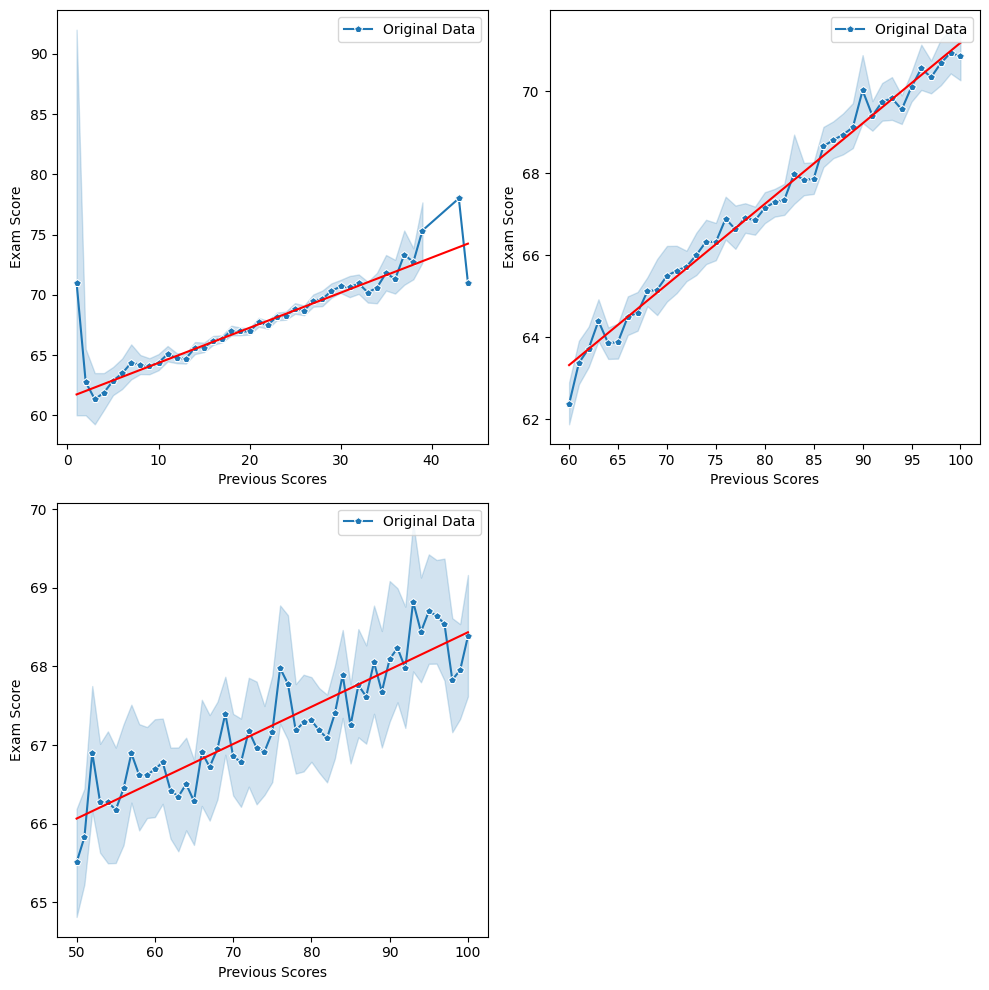

In [8]:
from sklearn.linear_model import LinearRegression
feature_pairs = [
    ('Hours_Studied', 'Exam_Score'),
    ('Attendance', 'Exam_Score'),
    ('Previous_Scores','Exam_Score'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i, (feature_x, feature_y) in enumerate(feature_pairs):

    X = df_normalized[[feature_x]].values
    y = df_normalized[feature_y].values

    lr = LinearRegression()
    lr.fit(X, y)
    X_test = np.linspace(min(X), max(X), 100).reshape(-1, 1)

    y_pred_linear = lr.predict(X_test)
    sns.lineplot(data=df_normalized, x=feature_x, y=feature_y, marker='p', label="Original Data",ax=axes[i])
    axes[i].plot(X_test, y_pred_linear, color='red', label='Linear Regression Fit')
    axes[i].set_xlabel("Previous Scores")
    axes[i].set_ylabel("Exam Score")

fig.delaxes(axes[-1])
plt.tight_layout()

plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_normalized.drop(columns=['Exam_Score'])  # Features
y = df_normalized['Exam_Score']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNN model
knn = KNeighborsRegressor(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mae)
print(mse)
print(r2)



1.6295715778474398
8.10884709160571
0.47817250116074717


#### MAE = 1.63 that mean the model's predictions are off by about 1.63 points on the exam score.
#### MSE & r2 shows a Unsatisfactory result


In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, mse_rf, r2_rf


(1.1227115987460814, 5.71954184952978, 0.6319311260738613)

#### The result is better than KNN.

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

#model architecture
model = Sequential()
model.add(Dense(units=128, activation='sigmoid', input_dim=X_train.shape[1]))
model.add(Dense(units=64, activation='sigmoid'))
# Output layer
model.add(Dense(units=1))  # a single output
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), verbose=0)


loss, mae = model.evaluate(X_test, y_test)

y_pred_dl = model.predict(X_test)

mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

mae, mse_dl, r2_dl


40/40 [==============================] - 0s 288us/step


(0.5826830267906189, 4.337003201554463, 0.7209014416528052)

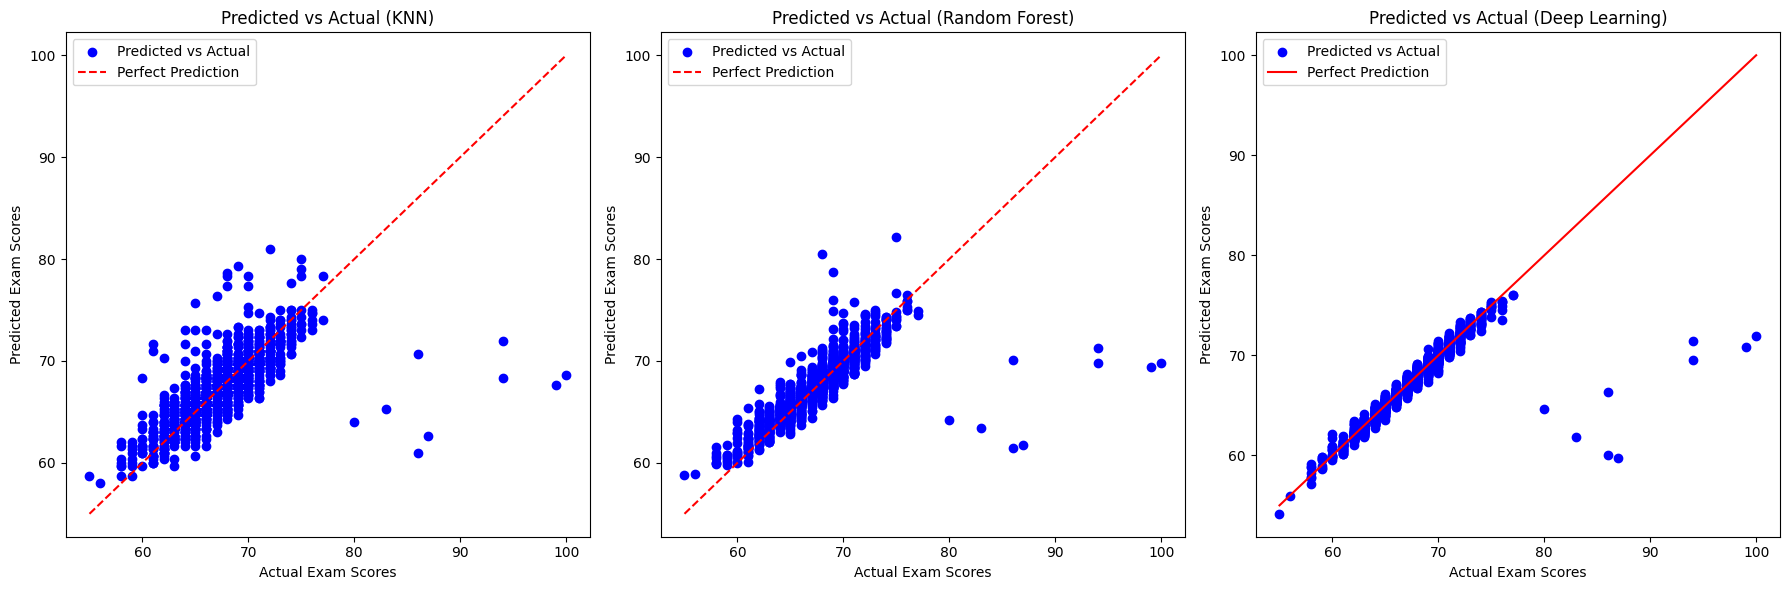

In [24]:
# Create a single figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KNN Model Plot
axes[0].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Exam Scores')
axes[0].set_ylabel('Predicted Exam Scores')
axes[0].set_title('Predicted vs Actual (KNN)')
axes[0].legend()

# Random Forest Model Plot
axes[1].scatter(y_test, y_pred_rf, color='blue', label='Predicted vs Actual')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Exam Scores')
axes[1].set_ylabel('Predicted Exam Scores')
axes[1].set_title('Predicted vs Actual (Random Forest)')
axes[1].legend()

# Deep Learning Model Plot
axes[2].scatter(y_test, y_pred_dl, color='blue', label='Predicted vs Actual')
axes[2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-', label='Perfect Prediction')
axes[2].set_xlabel('Actual Exam Scores')
axes[2].set_ylabel('Predicted Exam Scores')
axes[2].set_title('Predicted vs Actual (Deep Learning)')
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()
